## Assignment 2

#### Mengtong Zhang (mz500)



In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import pymc3 as pm
import theano
from theano import tensor as T
from pymc3.math import switch
import pandas as pd
import random 
import time
import matplotlib.pyplot as plt
import math
from pymc3 import get_data
from pymc3 import get_data, Deterministic, Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
%matplotlib inline

### Question 3 Programming: Stochastic Subgradient Descent
To accelerate the subgradient descent, we random choose samples for computing gradient.

In [43]:
data=pd.read_csv('/Users/zmt/Desktop/svm.csv')
X=data[['x','intercept']].values
Y=data['y'].values
label=data['class'].values

In [44]:
def compute_cost(W, X, Y):
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances > 0] = 1
    hinge_loss = abs(np.sum(distances) / N)
    return hinge_loss
def compute_gradient(W,X,Y,control_parameter):
    index=random.sample(range(0, len(X)),int(len(X)*control_parameter))
    dw=np.zeros(len(W))
    for i in index :
        if (Y[i]*np.dot(X[i], W)) < 1:
            di= (W-2*X[i] * Y[i])
        else:
            di=W
        dw+=di
    return dw/int(len(X)*control_parameter)
def svm(X,Y,control_parameter):
    w=np.array([-800,0])
    res=[]
    for epoch in range(1,201):
        w=w-1/(2*epoch)*compute_gradient(w,X,Y,control_parameter)
        loss=compute_cost(w, X, Y)
        res.append([epoch,w,loss])
    return w,res
w,res=svm(X,Y,0.7)

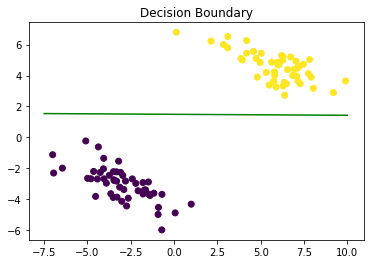

In [45]:
x_vals = np.linspace(-7.5,10,100)
y_vals = w[1] + w[0] * x_vals
plt.plot(x_vals, y_vals, '-',color='green')
plt.scatter(X[:,0],Y,c=label)
plt.title('Decision Boundary')
plt.show()

Text(0.5, 1.0, 'Loss vs Time')

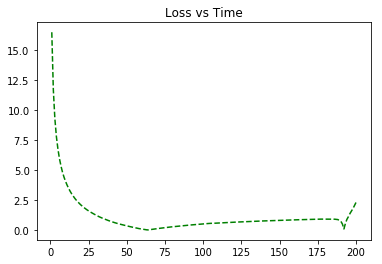

In [46]:
res=np.array(res)
plt.plot(res[:,0],res[:,2],'--',color='green')
plt.title('Loss vs Time')

Text(0.5, 1.0, 'Run time for different sizes of n')

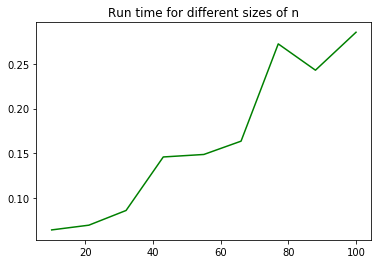

In [47]:
import time
run_time=[]
for i in np.linspace(0.1,1.0,9):
    start = time.time()
    svm(X,Y,i)
    stop = time.time()
    run_time.append([int(i*len(X)), stop-start])
run_time=np.array(run_time)
plt.plot(run_time[:,0],run_time[:,1],'-',color='green')
plt.title('Run time for different sizes of n')

### Question 7: Programming a Gibbs Sampler

In [42]:
data = pd.read_csv('/Users/zmt/Desktop/gibbs.csv')
n = len(data.value)
beta = 4
alpha = 30
lam = np.random.gamma(sum(data.value)+alpha,beta/(n*beta+1),1000)

In [43]:
def ll(lam):
    res=1
    for v in data.value:
        res*=stats.poisson.pmf(v,lam)
    return -math.log(res)

In [18]:
stats.poisson.pmf(1,7)

0.0063831737588816145

Text(0.5, 1.0, 'Likelihood Function Value for different lambda')

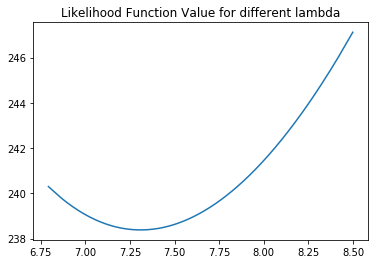

In [44]:
lam.sort()
plt.plot(lam,[ll(l) for l in lam])
plt.title('Likelihood Function Value for different lambda')

In [24]:
ll(6)

-251.7466693639032

Text(0.5, 1.0, 'Posterior Distribution')

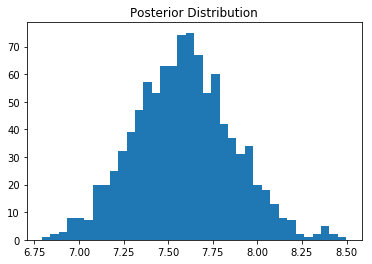

In [53]:
plt.hist(lam,bins = 36)
plt.title('Posterior Distribution')

Text(0.5, 1.0, 'Posterior Predictive Distribution')

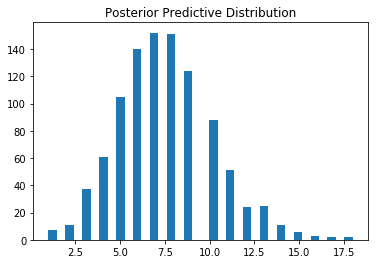

In [54]:
plt.hist(np.random.poisson(sum(lam)/len(lam),1000),bins=36)
plt.title('Posterior Predictive Distribution')

### Question 8: Change points models

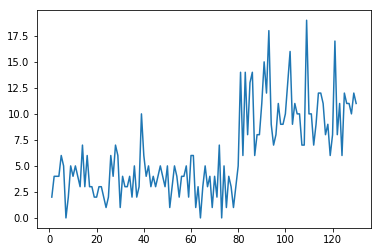

In [3]:
data=pd.read_csv('/Users/zmt/Desktop/change_point1.csv')
plt.plot(data['x'],data['y'])
plt.show()

In [4]:
n = 5000 
t = np.arange(0,len(data)) 
data=data['y'].values
model = pm.Model()

with model:
    alpha=pm.Exponential('alpha',1/np.mean(data))
    beta=pm.Exponential('beta',1/np.mean(data))
    tau=pm.DiscreteUniform("tau",t.min(),t.max())
    lambda_=T.switch(tau>=t, alpha, beta)
    logp = -lambda_ + T.log(lambda_)*data

with model:
    def logp_func(data):
        return logp.sum()
    L_obs=pm.DensityDist('L_obs',logp_func, observed=data)
    start = pm.find_MAP()
    trace = pm.sample(n, start=start, random_seed=111, progressbar=True)

logp = 615.43, ||grad|| = 292.24: 100%|██████████| 9/9 [00:00<00:00, 854.78it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [beta, alpha]
>Metropolis: [tau]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:08<00:00, 1299.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119c964a8>,
      dtype=object)

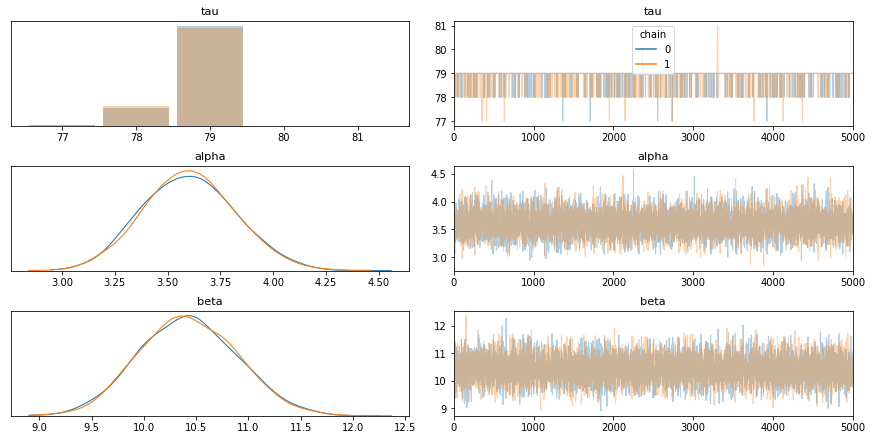

In [5]:
pm.traceplot(trace,legend=True)

### Question 9: Programming a hierarchical model using PYMC3

In [2]:
data=pd.read_csv('/Users/zmt/Desktop/radon.csv')

In [3]:
data['fips'] = data.stfips*1000 + data.cntyfips

In [4]:
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn['fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = data.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)
n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

In [7]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

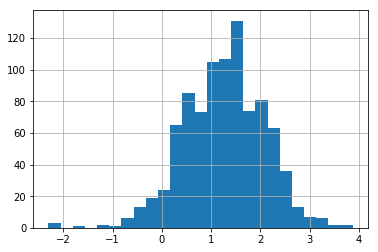

In [11]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

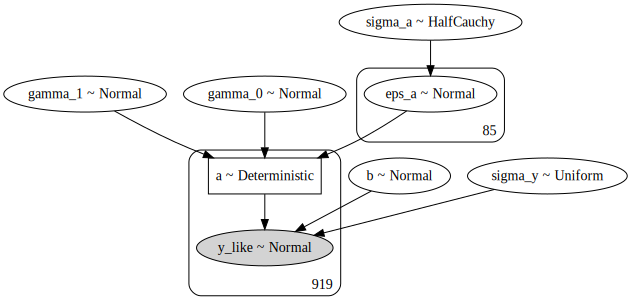

In [12]:
with Model() as hierarchical_intercept:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sigma=1e5)
    gamma_1 = Normal('gamma_1', mu=0., sigma=1e5)


    # Uranium model for intercept
    mu_a = gamma_0 + gamma_1*u
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sigma=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=1e5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

model_to_graphviz(hierarchical_intercept)

In [13]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b, eps_a, gamma_1, gamma_0, sigma_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 255.48draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1220c6fd0>,
      dtype=object)

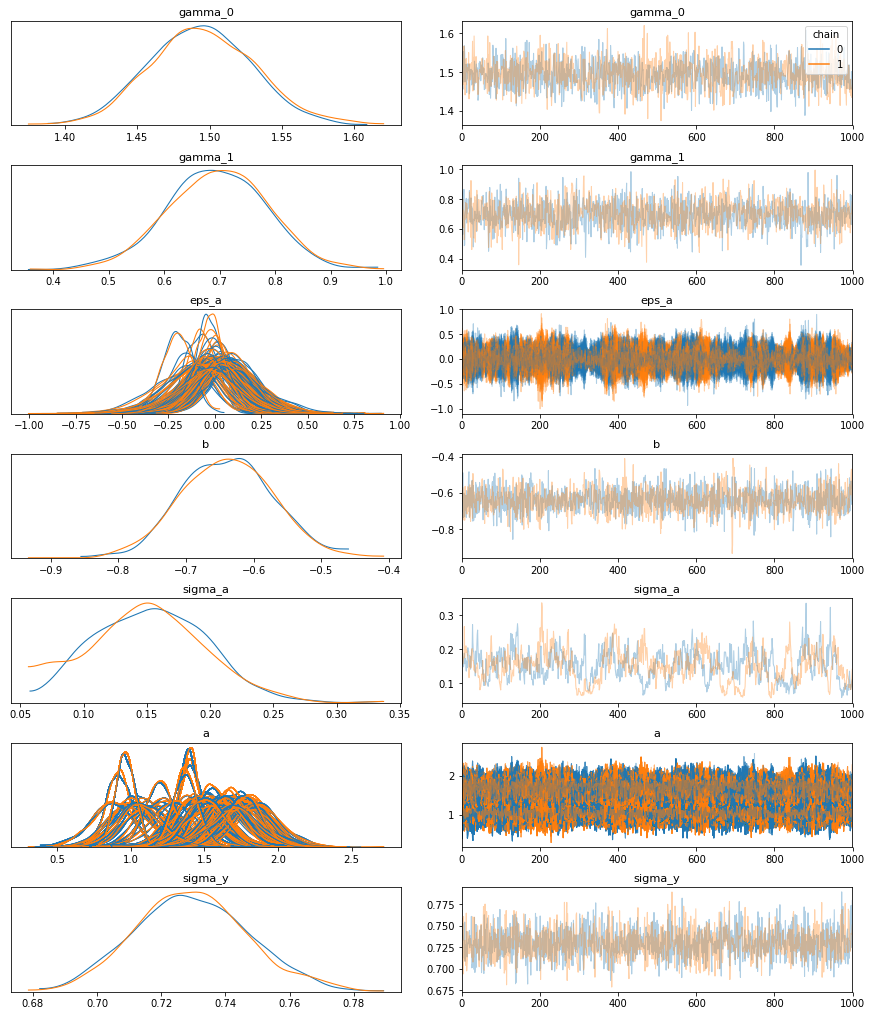

In [18]:
import warnings
warnings.filterwarnings("ignore")
pm.traceplot(hierarchical_intercept_trace,legend=True)

Text(0, 0.5, 'Intercept estimate')

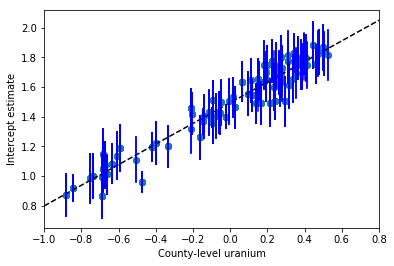

In [19]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(u, a_means)
g0 = hierarchical_intercept_trace['gamma_0'].mean()
g1 = hierarchical_intercept_trace['gamma_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(u, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate')

In [38]:
ma = hierarchical_intercept_trace['a'].mean(axis=0)
mb = hierarchical_intercept_trace['b'].mean(axis=0)
data['predict_uranium'] = [ma[i]+mb*floor_measure[i] for i in range(len(ma))]

In [40]:
newdata=data[['county','predict_uranium']].groupby('county').mean().reset_index()

In [50]:
newdata.loc[newdata['predict_uranium'].idxmax()]

county             STEVENS             
predict_uranium                 1.82679
Name: 72, dtype: object

In [51]:
newdata.loc[newdata['predict_uranium'].idxmin()]

county             KOOCHICHING         
predict_uranium                 0.50123
Name: 34, dtype: object

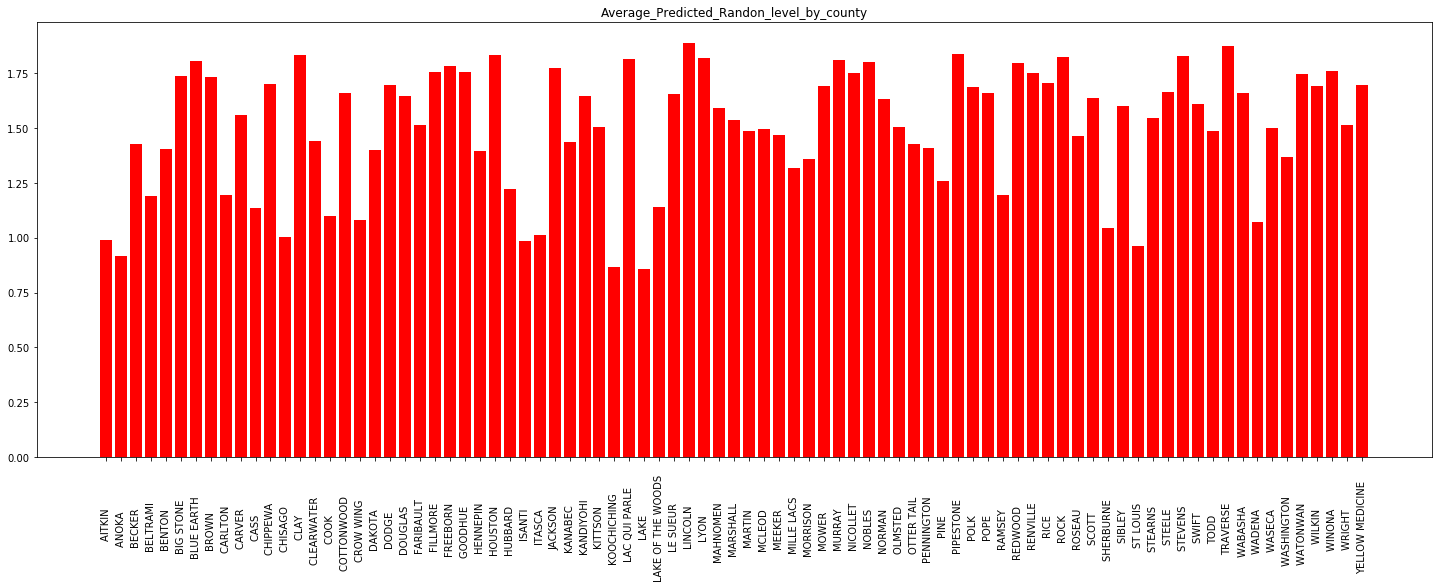

In [42]:
plt.figure(figsize=(25,8))
plt.bar(data['county'],data['predict_uranium'],color='red')
plt.xticks(rotation='vertical')
plt.title('Average_Predicted_Randon_level_by_county')
plt.show()